In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import copy


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Itu


In [ ]:
# Define transformations for data augmentation (for the training set only)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation and test transforms (no data augmentation)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Pneumonia Detection dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='/Users/itirohilla/Documents/Courses/Quarter4/SessionB/Week2/chest_xray_new/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/Users/itirohilla/Documents/Courses/Quarter4/SessionB/Week2/chest_xray_new/val', transform=transform_val_test)
test_dataset = datasets.ImageFolder(root='/Users/itirohilla/Documents/Courses/Quarter4/SessionB/Week2/chest_xray_new/test', transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Iti


In [ ]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  # Output for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = PneumoniaCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Iti


In [ ]:
# Early stopping parameters
patience = 3
best_val_loss = np.inf
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights
model.load_state_dict(best_model_wts)


Epoch 1/20, Train Loss: 0.4489, Val Loss: 1.1475
Epoch 2/20, Train Loss: 0.1456, Val Loss: 1.1409
Epoch 3/20, Train Loss: 0.1361, Val Loss: 0.4691
Epoch 4/20, Train Loss: 0.1203, Val Loss: 1.1304
Epoch 5/20, Train Loss: 0.1068, Val Loss: 0.6746
Epoch 6/20, Train Loss: 0.1026, Val Loss: 0.4067
Epoch 7/20, Train Loss: 0.0891, Val Loss: 0.7234
Epoch 8/20, Train Loss: 0.0901, Val Loss: 0.5663
Epoch 9/20, Train Loss: 0.0935, Val Loss: 0.7416
Early stopping triggered
iti


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


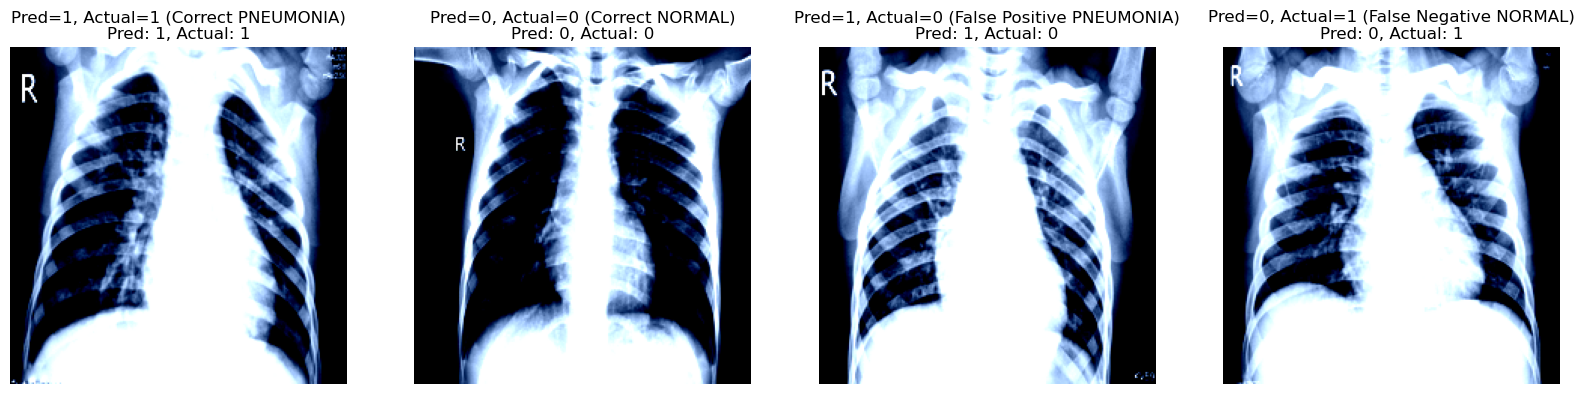

Itu


In [ ]:
import random
import matplotlib.pyplot as plt

# Helper function to get indices of images matching specific conditions
def get_image_sample(condition, num_samples=1):
    sample_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if condition(pred, label)]
    selected_indices = random.sample(sample_indices, min(num_samples, len(sample_indices)))
    return selected_indices

# Define conditions for each case
conditions = {
    "Pred=1, Actual=1 (Correct PNEUMONIA)": lambda pred, label: pred == 1 and label == 1,
    "Pred=0, Actual=0 (Correct NORMAL)": lambda pred, label: pred == 0 and label == 0,
    "Pred=1, Actual=0 (False Positive PNEUMONIA)": lambda pred, label: pred == 1 and label == 0,
    "Pred=0, Actual=1 (False Negative NORMAL)": lambda pred, label: pred == 0 and label == 1
}

# Retrieve images from the test_loader based on conditions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

# Flatten the test_loader for easy indexing
test_images = []
test_labels = []
for inputs, labels in test_loader:
    test_images.extend(inputs)
    test_labels.extend(labels)

for i, (title, condition) in enumerate(conditions.items()):
    sample_indices = get_image_sample(condition, num_samples=1)
    if sample_indices:
        idx = sample_indices[0]
        img = test_images[idx]
        true_label = test_labels[idx]

        # Plotting
        axes[i].imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[i].set_title(f"{title}\nPred: {all_preds[idx]}, Actual: {all_labels[idx]}")
        axes[i].axis("off")
    else:
        axes[i].axis("off")
        axes[i].set_title(f"No samples for {title}")

plt.show()





Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.56      0.69       234
   Pneumonia       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



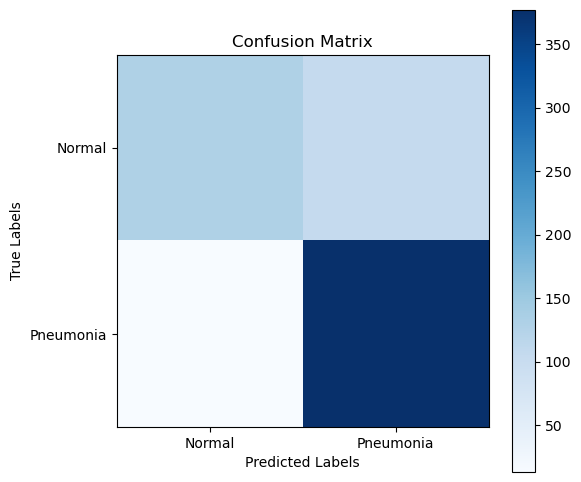

Itu


In [ ]:
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Collect predictions and labels for the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

# Confusion matrix for visualizing best- and worst-performing classes
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.xticks(np.arange(2), ['Normal', 'Pneumonia'])
plt.yticks(np.arange(2), ['Normal', 'Pneumonia'])
plt.show()


